In [3]:
import math
import numpy as np
from combined_model.hrr import *
import random
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
# Policy for choosing left or right
def policy_mov(state, wm, rand_on):
    
    # Calculates what the left and right positions on the maze are
    if (state == 0):
        state_left = size_of_maze - 1
        state_right = state + 1
    elif (state == size_of_maze - 1):
        state_left = state - 1
        state_right = 0
    else:
        state_left = state - 1
        state_right = state + 1
    
    # Value of each move
    value_left_state_wm = np.dot(weights, ltm.encode(build_hrr_string(wm, state_left))) + bias
    value_right_state_wm = np.dot(weights, ltm.encode(build_hrr_string(wm, state_right))) + bias
    
    # Random move
    if((np.random.random() < e_soft) and (rand_on == 1)):
        return np.random.choice([state_left, state_right])
    
    # Finds best move
    max_value = max(value_left_state_wm, value_right_state_wm)
    
    # Returns best move
    if(max_value == value_left_state_wm):
        return state_left
    elif(max_value == value_right_state_wm):
        return state_right
    
# Switching wm depending on td error
def policy_switch(wm):
    return (wm + 1)%2

def build_hrr_string(wm, state):
    return "WM:" + str(wm) + "*" + "State:" + str(state)

In [5]:
# Size of hrrs
hrr_length = 4096
normalized = True

goal_states =  [5, 15]

# Maze creation
size_of_maze = 20

# Reward for learning
reward_bad = 0
reward_good = 1

# Discounted future rewards
discount = 0.9

# Learning rate
alpha = 0.05

# Exploration on or off
exp_on = 1

# Exploration rate
e_soft = 0.001

# Treshold to switch wm
threshold = -0.2

# Number of training cycles
episodes = 100000
opt_after = 90000
non_obs_task_switch_rate = 100
num_non_obs_tasks = len(goal_states)

# Steps to try finding the goal before quiting
steps_till_quit = 200

# Frequency to print information
print_freq = 100

# wm is set to first
current_wm = 0

# Neural network
weights = hrr(hrr_length, True)
bias = 1

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.05

In [6]:
def get_opt_steps(start, goal, size_of_maze):
    opt = abs(goal - start)
    if opt > size_of_maze / 2:
        opt = size_of_maze - opt
    return opt

In [7]:
ltm = LTM("hrrs_" + str(hrr_length), hrr_length, normalized)

In [11]:
print("Goals:", goal_states[0], goal_states[1])

non_obs = 0
opt_count = 0
calc = False


for x in range(episodes):
    
    # Current state
    current_state = random.randint(0, size_of_maze - 1)
        
    goal_state = goal_states[non_obs]
    
    # Reset trace
    eligibility *= 0.0



    for y in range (steps_till_quit):

        # Store info about previous state
        previous_state = current_state
        
        encode_str = build_hrr_string(current_wm, previous_state)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = np.dot(weights, previous_state_hrr) + bias  
        
        
        eligibility *= eli_lambda
        
        move = policy_mov(current_wm, previous_state, exp_on)
        
        current_state = state
        
        encode_str = build_hrr_string(current_wm, previous_state)
        current_state_hrr = ltm.encode(encode_str)
        current_value = np.dot(weights, current_state_hrr) + bias  

        if current_state == goal_state:
            encode_str = build_hrr_string(current_wm, str(current_state) + "*rewardTkn")
            goal_value = np.dot(weights, encode_str) + bias  
            
            
            error = (reward_bad + discount * goal_value + bias) - previous_value
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * error * eligibility))
            
            
            error = reward_good - goal_value + bias
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * error * eligibility))
            
            break
            
        # Weight update for goal not found
        error = (reward_bad + discount * current_value) - previous_value
        eligibility = eligibility + previous_state_hrr
        if error < threshold:
            current_wm = policy_switch(current_wm)
            eligibility *= 0.0
            break
        weights = np.add(weights, (alpha * error * eligibility))
        
    if (x+1)%print_freq == 0:
        print("Episode", x+1, "done")


    
#     # Current state
#     current_state = random.randint(0, size_of_maze - 1)

#     if x%non_obs_task_switch_rate == 0:
#         non_obs = (non_obs+1)%num_non_obs_tasks
        
#     goal_state = goal_states[non_obs]
    
#     opt_steps = get_opt_steps(current_state, goal_state, size_of_maze)
#     steps = 0
    
#     # Reset trace
#     eligibility *= 0.0

#     for y in range (steps_till_quit):
        
#         # Goal reached
#         if (current_state == goal_state):
#             encode_str = build_hrr_string(current_wm, str(current_state) + "*rewardTkn")
#             goal_hrr = ltm.encode(encode_str)
#             goal_value = np.dot(weights, goal_hrr) + bias   
            
#             error = reward_good - goal_value
#             eligibility *= eli_lambda
#             eligibility = eligibility + goal_hrr
#             weights = np.add(weights, (alpha * error * eligibility))
            
#             break
        
#         # Store info about previous state
#         previous_state = current_state
#         previous_wm = current_wm
#         previous_value = np.dot(weights, ltm.encode(build_hrr_string(previous_wm, current_state))) + bias
        
#         encode_str = build_hrr_string(previous_wm, previous_state)
#         previous_state_hrr = ltm.encode(encode_str)
#         previous_value = np.dot(weights, previous_state_hrr) + bias        
        
#         # What state to move into
#         move = policy_mov(previous_wm, previous_state, exp_on)
        
#         if (x + 1) > opt_after:
#             calc = True
#             exp_on = 0
            
#         if calc:
#             steps += 1
        
#         # Make the move
#         current = move
        
#         current_state = current
        
#         if current_state == goal_state:
#             encode_str = build_hrr_string(current_wm, str(current_state) + "*rewardTkn")
#             previous_state_hrr = ltm.encode(encode_str)
#             goal_value = np.dot(weights, previous_state_hrr) + bias   
            
#             error = reward_good - goal_value
#         else:
#             encode_str = build_hrr_string(current_wm, current_state)
        
#             current_state_hrr = ltm.encode(encode_str)
#             current_value = np.dot(weights, current_state_hrr) + bias   

#             # Weight update for goal not found
#             error = (reward_bad + discount * current_value) - previous_value
#             if error < threshold:
#                     current_wm = policy_switch(previous_wm)
#                     if calc:
#                         steps = 0
#                         opt_steps = get_opt_steps(current_state, goal_state, size_of_maze)
#                     eligibility *= 0.0
#                     break
                    
#         eligibility *= eli_lambda
#         eligibility = eligibility + previous_state_hrr
#         weights = np.add(weights, (alpha * error * eligibility))
        
#     if steps == opt_steps and calc:
#         opt_count += 1
        
#     if (x+1)%print_freq == 0:
#         print("Episode", x+1, "done")
       
# print(opt_count, episodes-opt_after)
# print(opt_count/(episodes-opt_after))

Goals: 5 15
Episode 100 done
Episode 200 done
Episode 300 done


KeyboardInterrupt: 

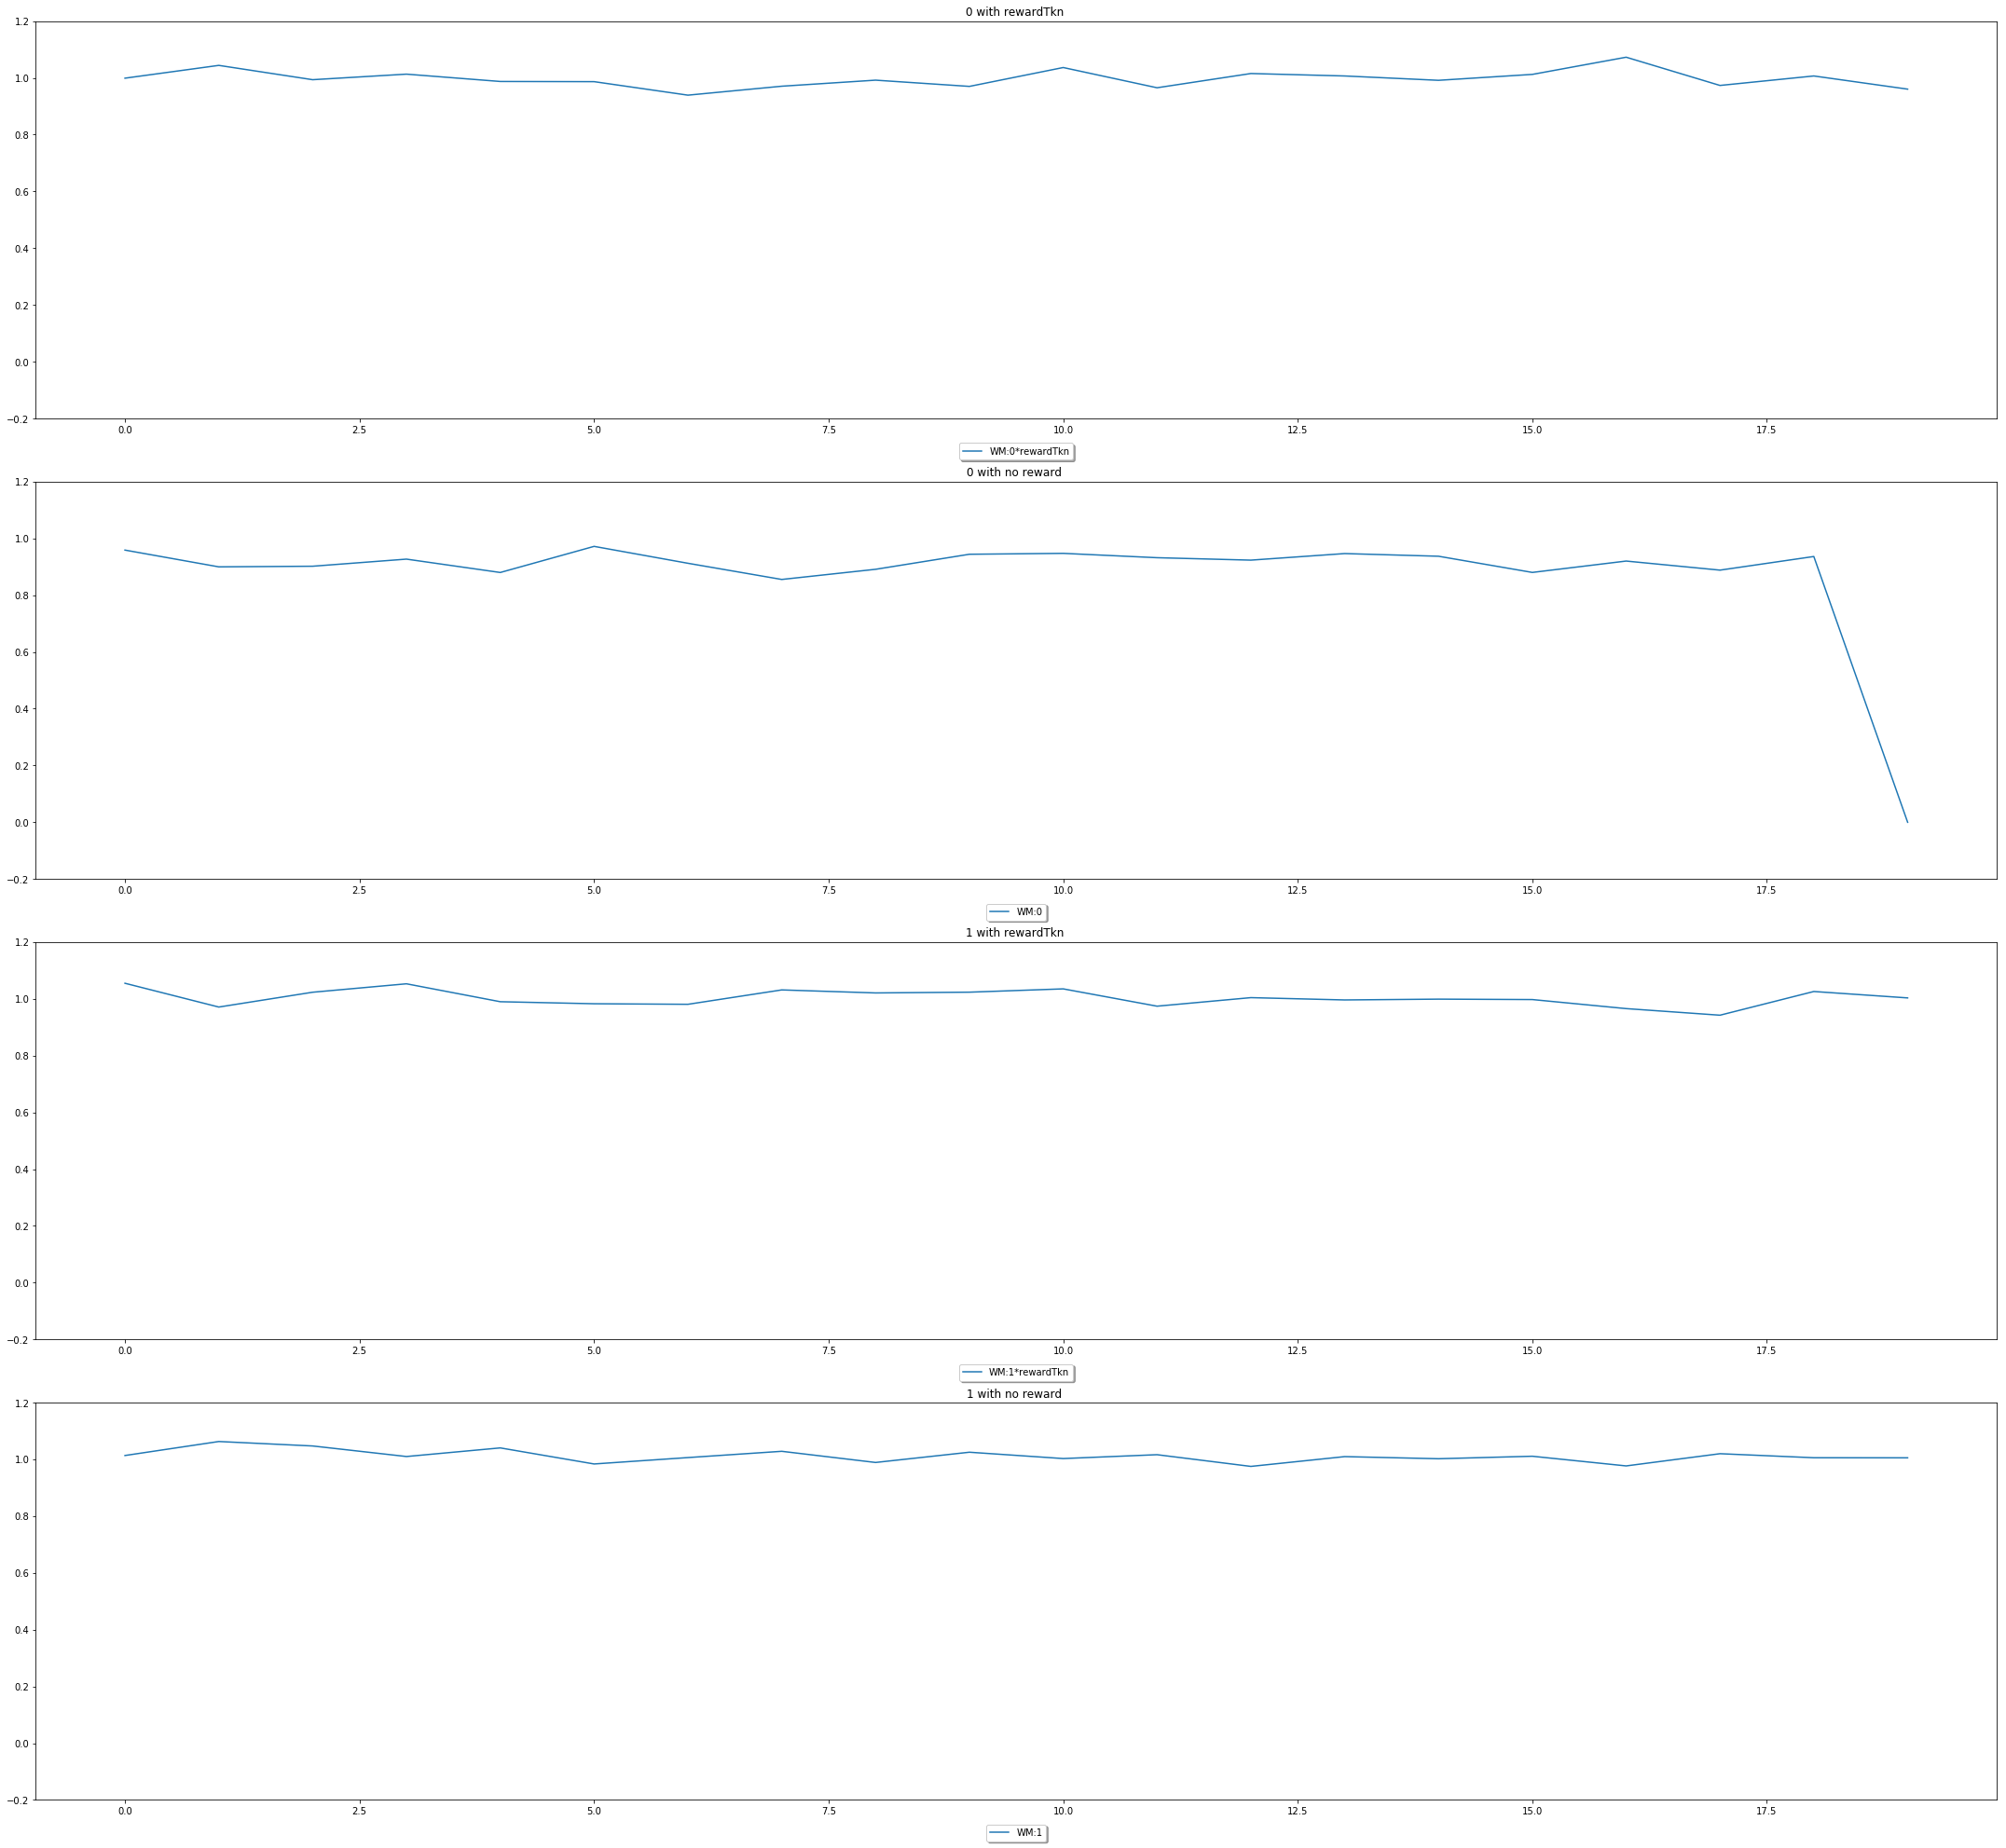

In [12]:
fig, axes = plt.subplots(nrows=num_non_obs_tasks * 2)
fig.set_figwidth(30)
fig.set_figheight(30)

for wm in range(num_non_obs_tasks):
    
    x_ind = wm * 2
    
    y_for_rwd = 0
    y_for_no_rwd = 0
    
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    for state in range(size_of_maze):
        encode_str = build_hrr_string(wm, str(state) + "*rewardTkn")
        value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
        
    axes[x_ind].title.set_text(str(wm) + " with rewardTkn ")
    axes[x_ind].set_ylim([-0.2, 1.2])
    label = "WM:" + str(wm) + "*rewardTkn"
    axes[x_ind].plot(position, value, label=label)

    axes[x_ind].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        fancybox=True, shadow=True, ncol=1, prop={'size': 10})
       
        
    value = np.zeros(size_of_maze)
    for state in range(size_of_maze):
        encode_str = build_hrr_string(wm, state)
        value[state] = np.dot(weights, ltm.encode(encode_str)) + bias

    axes[x_ind+1].title.set_text(str(wm) + " with no reward ")
    axes[x_ind+1].set_ylim([-0.2, 1.2])
    label = "WM:" + str(wm)
    axes[x_ind+1].plot(position, value, label=label)

    axes[x_ind+1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=1, prop={'size': 10})
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
ltm.clean
del ltm